In [174]:
import vnstock as vns
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from MFI import add_mfi
from RSI import add_rsi
from MACD import add_macd
from cosine import cosine
from bollinger_bands import add_bollinger_bands

In [175]:
ticker = 'VCB'

In [176]:
df = vns.stock_historical_data(symbol = ticker, start_date="2014-01-01", 
                            end_date='2024-06-01', resolution='1D', type='stock')


In [177]:

def calculate_indicators(data):
    add_mfi(data)
    
    data = data[['time', 'close', 'MFI']]

    # data.set_index('time', inplace = True)

    data = data.dropna()

    data['sma10'] = data['close'].rolling(window = 10, min_periods = 1).mean()
    
    data['sma50'] = data['close'].rolling(window = 50, min_periods = 1).mean()
    
    data['ema'] = data['close'].ewm(span = 10).mean()
    
    add_bollinger_bands(data)

    add_rsi(data)

    add_macd(data)

    data.dropna(inplace= True)

    return data


In [178]:
df = calculate_indicators(df)

In [179]:
def RSI_signal(data, index):
    if data['RSI'].iloc[index] <= 70 and data['RSI'].iloc[index - 1] >= 70:
        return -1
    elif data['RSI'].iloc[index] >= 30 and data['RSI'].iloc[index - 1] <= 30:
        return 1
    else:
        return 0

In [180]:
def MFI_signal(data, index):
    if data['MFI'].iloc[index] <= 80 and data['MFI'].iloc[index - 1] >= 80:
        return -1
    elif data['MFI'].iloc[index] >= 20 and data['MFI'].iloc[index - 1] <= 20:
        return 1
    else:
        return 0

In [181]:
def MACD_signal(data, index):
    if data['MACD'].iloc[index] >= data['Signal_Line'].iloc[index] and \
        data['MACD'].iloc[index - 1] <= data['Signal_Line'].iloc[index - 1]:
        return -1
    elif data['MACD'].iloc[index] <= data['Signal_Line'].iloc[index] and \
        data['MACD'].iloc[index - 1] >= data['Signal_Line'].iloc[index - 1]:
        return 1    
    else:
        return 0

In [182]:
def bollinger_bands_signal(data, index):
    if data['close'].iloc[index] <= data['LB'].iloc[index] and \
        data['close'].iloc[index - 1] >= data['LB'].iloc[index - 1]:
        return 1
    elif data['close'].iloc[index] >= data['UB'].iloc[index] and \
        data['close'].iloc[index - 1] <= data['UB'].iloc[index - 1]:
        return -1
    else:
        return 0

In [183]:
def pattern_matching(df, start, window, indicator):
    df_temp = df[indicator].copy()
    if (start + window >= len(df_temp)) or (start < window):
        return 'Range not found'
    df_window = df_temp.iloc[start:start + window]
    df_window -= df_window.iloc[0]
    cosines = []
    for i in range(start - window):
        df_compare = df_temp.iloc[i:i+window].copy()
        df_compare -= df_compare.iloc[0]
        cosines.append(cosine(df_window, df_compare, window))
    return cosines.index(max(cosines))

In [184]:
def matching_signal(data, index):
    pattern_start = pattern_matching(data, index, window, indicator)
    predicted_earnings = data[indicator].iloc[pattern_start + window + forward_window - 1] - data[indicator].iloc[pattern_start + window - 1]
    
    if predicted_earnings > 0:
        return 0.2
    else:
        return -0.2

In [185]:
def calculate_signal(data, index):
    return RSI_signal(data, index) + MFI_signal(data, index) + MACD_signal(data, index) + \
        bollinger_bands_signal(data, index) + matching_signal(data, index)

In [186]:
len(df)

2576

In [187]:
indicator = 'close'
start = 2500  # At which point to start investing
df_matching = df.copy()
budget = 10000000  # How much money to start with, doesnt really matter
total_assets = [10000000]
window = 5
forward_window = 5
stocks_holding = 0
buy_points = []
sell_points = []
signal = 0

In [188]:
print(RSI_signal(df_matching, 2000))
()

0


()

In [189]:
while start + forward_window < len(df_matching):
   current_price = df_matching['close'].iloc[start+window- 1]
   signal = signal + calculate_signal(df_matching, start + window - 1)
   if signal >= 2:
      buy_points.append(start + window - 1)

      stocks_to_buy = (budget // 2) // current_price  #Spends half the budget to buy
      print(f'Bought {stocks_to_buy} stock.', end = ' ')

      budget -= stocks_to_buy * current_price
      stocks_holding += stocks_to_buy

      print(f'{budget}$ remaining.', end = ' ')

   elif (signal <= -2) and (stocks_holding > 0):

      sell_points.append(start + window - 1)

      budget += stocks_holding * current_price

      stocks_sold = stocks_holding

      print(f'Sold {stocks_sold} stocks. {budget}$ remaining.', end = ' ')
      stocks_holding -= stocks_sold

   total_assets.append(budget + stocks_holding*current_price)
   start += 1
   print(f'Current stock price: {current_price}. Holding {stocks_holding}. Current total assets: {total_assets[-1]}\n')

   if signal >= 0:
      signal = max(0, signal - 0.2)
   elif signal < 0:
      signal = min(0, signal + 0.2)
   # Decaying the signal

current_price = df_matching[ticker].iloc[-1]
total_assets.append(budget + stocks_holding * current_price)
print(f'Current total assets: {total_assets[-1]}. ')

Current stock price: 89600. Holding 0. Current total assets: 10000000

Current stock price: 90200. Holding 0. Current total assets: 10000000

Current stock price: 91300. Holding 0. Current total assets: 10000000

Current stock price: 91200. Holding 0. Current total assets: 10000000

Current stock price: 89500. Holding 0. Current total assets: 10000000

Current stock price: 88900. Holding 0. Current total assets: 10000000

Current stock price: 89500. Holding 0. Current total assets: 10000000

Current stock price: 91100. Holding 0. Current total assets: 10000000

Current stock price: 97400. Holding 0. Current total assets: 10000000

Current stock price: 97300. Holding 0. Current total assets: 10000000

Current stock price: 97300. Holding 0. Current total assets: 10000000

Current stock price: 96000. Holding 0. Current total assets: 10000000

Current stock price: 95500. Holding 0. Current total assets: 10000000

Current stock price: 95600. Holding 0. Current total assets: 10000000

Curren

TypeError: can only concatenate str (not "int") to str

In [ ]:
print(f'Profit/loss is: {(total_assets[-1] - total_assets[0])/total_assets[0] * 100}%')

Profit/loss is: -0.752%


In [ ]:
start = 2500
print(f'Stock grew by: {(df[ticker].iloc[-1] - df_matching[ticker].iloc[start + window - 1])/df[ticker].iloc[start + window - 1] * 100}%')

Stock grew by: 125.97200622083982%


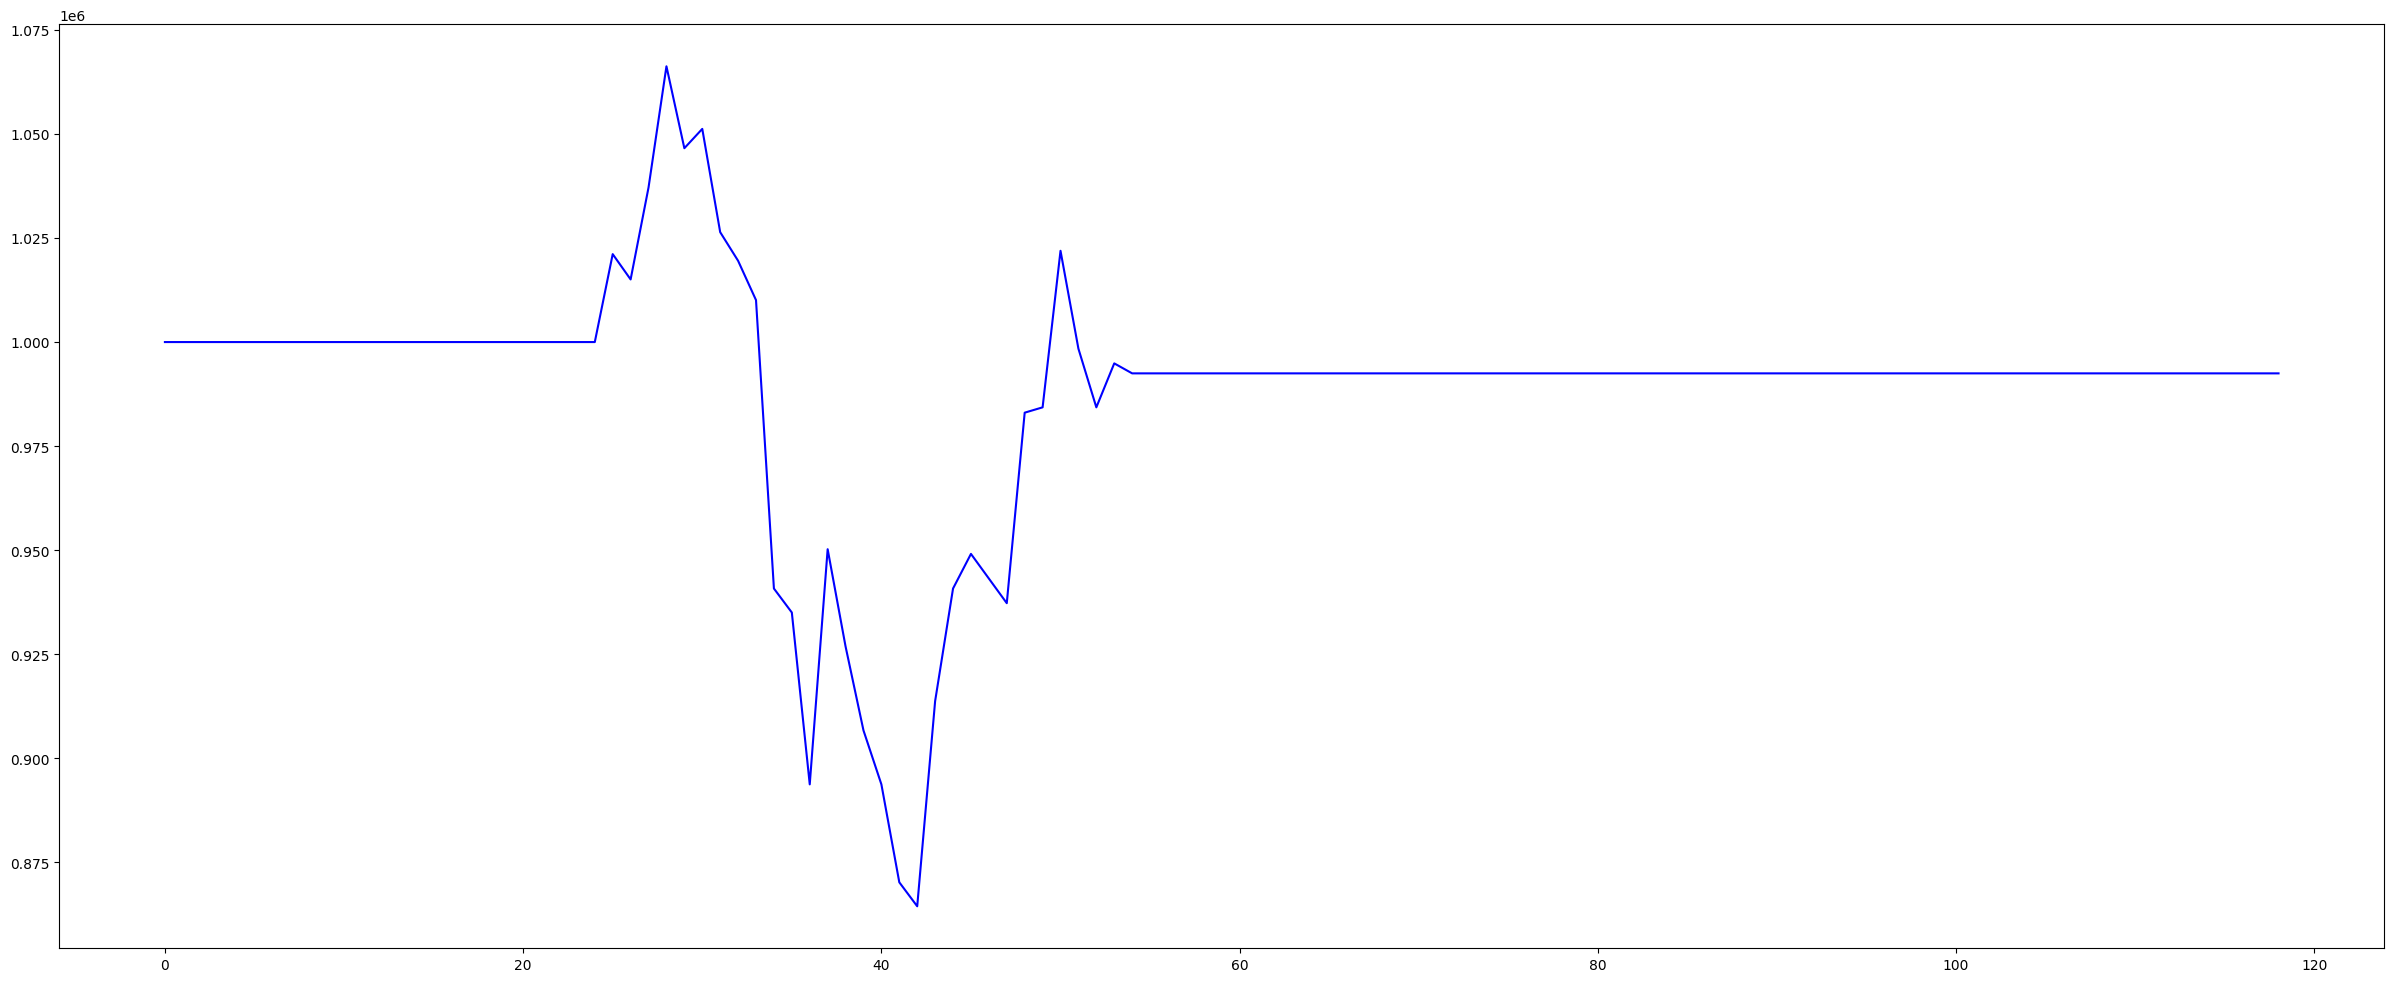

In [ ]:
plt.subplots(figsize =(30,12))
plt.plot(total_assets, label = "data", color = "b")

C:\Users\huyvu\AppData\Local\Temp\ipykernel_25160\3095873445.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(df.index[start:][[i - start for i in buy_points]], df[ticker][start:][[i - start for i in buy_points]],
C:\Users\huyvu\AppData\Local\Temp\ipykernel_25160\3095873445.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(df.index[start:][[i - start for i in sell_points]], df[ticker][start:][[i - start for i in sell_points]],


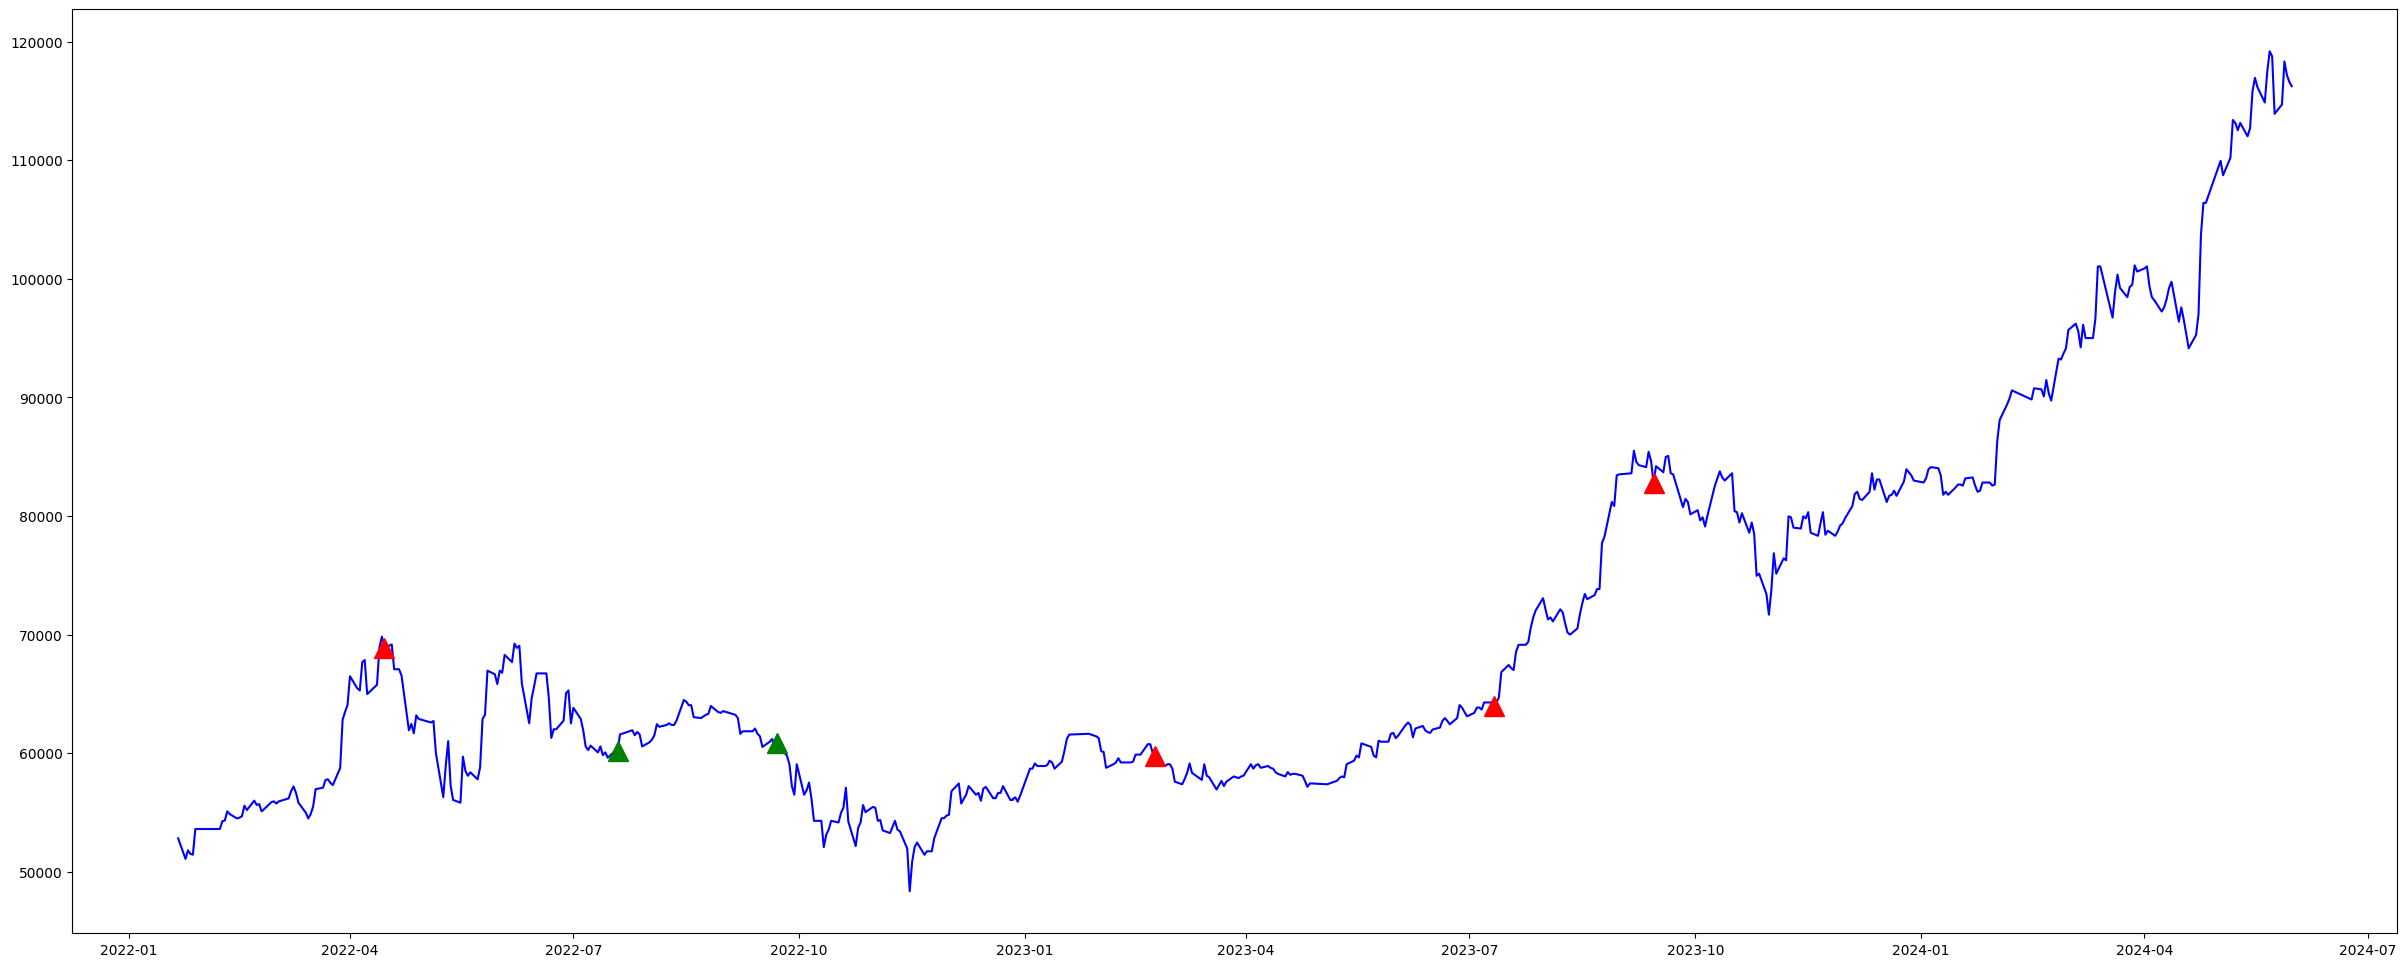

In [ ]:
start = 2000
plt.subplots(figsize =(30,12))
plt.plot(df[ticker][start:], label = "data", color = "b")
plt.plot(df.index[start:][[i - start for i in buy_points]], df[ticker][start:][[i - start for i in buy_points]],
'^', ms=15, label='Buy Signal', color='green')
plt.plot(df.index[start:][[i - start for i in sell_points]], df[ticker][start:][[i - start for i in sell_points]],
'^', ms=15, label='Buy Signal', color='red')